<big><b><i>Data Investigation Notebook: 2021 brainSPORT rsfMRI TBI Literature Review</i></b></big>


<b>README</b>: This script was written July 14th, 2021 by Daniel Frees, an undergraduate student of UCLA for use by a research team at the Steve Tisch brainSPORT Lab. If you wish to reuse some or all of this code for other purposes email me: danielfrees@g.ucla.edu

Input directories for the CSV files containing your meta-analysis info. All of the necessary edits can be performed in the Directory class, by editing the baseDir (base directory) and the additional specific locations of each network file. 

<b>Functions: </b>

----
cleanData(datalist): cleanData() takes in a list of pandas dataframes (these are generated in my code shortly below the directory inputs), and outputs clean dataframes for the columns relevant to our analysis. I used natural language processing (NLP) to determine what our final verdict for each result/classification was, and then edited the output list of dataframes accordingly. 

•Rules: the final determined Result must be written leftmost in its cell so the correct keyword can be identified. Results and Chronicities must be listed for each finding, but other classifications will autofill down wherever they have not been filled in (as we typically only wrote these out for the first finding of a given paper). Certain mispellings and miscapitalizations are allowed, but I did not write a full Trie or other spellchecker, so try to avoid typos as much as possible. I made sure through multiple iterations that this was catching all of our most common mispellings/ miscaps.

-----
runStats(datalist, stats): runStats() takes in a list of pandas dataframes (these should be the cleaned ones output from cleanData()) as well as a 2D 'stats' list (a list of size 2 lists, where each size 2 list is a pair: a classification, and a count of how many times that classification shows up in the data (this should start at 0 for all classifications the same way I initially set up my stats object). It outputs a modified 2D 'stats' list with the counts added up for each classification after parsing through the provided datalist.

•Rules: Mostly just be careful to pass a stats 2D list which has counts of 0 for everything if you want an accurate analysis of the dataframes you passed in. Furthermore, generating the stats object is performed immediately about this function definition in my code, and could be altered for an alternate classification system. 

----
queryStats(stats, weight = "UW", query1="", query2="", query3="", query4="", query5="", query6=""): queryStats() allows you to input a stats 2D list (presumably resulting from runStats), as well as 0 or more queries (a query is a string matching a possible type of result such as "dmn" for default mode network results, etc.) and outputs a list of [increase decrease null] results, in that order. This function is integral to printStats.

The only additional thing you need to do compared to the pre-08/11/2021 code is provide a weighting option as your second parameter:
"UW" - uses unweighted results;
"W-TBI" - uses TBI sample size weighted results;
"W-Total" - uses Total sample size weighted results

----
printStats(stats): printStats() uses queryStats to generate a bunch of pandas dataframes corresponding to relevant outputs for our literature review, making visualization of a ton of different subsections of our results easy and clear.

----
**easyQueryStats(stats, weight = "UW", query1="", query2="", query3="", query4="", query5="", query6="")**: easyQueryStats() works almost exactly like queryStats except it prints out a mini dataframe of your requested statistics, making it easier to use without additional coding. 

**The only additional thing you need to do compared to the pre-08/11/2021 code is provide a weighting option as your second parameter:**
"UW" - uses unweighted results;
"W-TBI" - uses TBI sample size weighted results;
"W-Total" - uses Total sample size weighted results

•This is the function to use if you want to investigate the data in the easiest way possible. Simply go into a new cell and call the function away. An example has been provided in the bottom-most codeblock in this notebook

•Note that if you hop on the notebook and only want to use this function you will still need to run each of the preceding code blocks in order, so that the necessary stats object will be created for you.

•**BE SUPER CAREFUL THAT YOUR QUERIES CORRESPOND TO THESE KEYWORDS OR YOUR COUNTS WON'T BE AS EXPECTED! I did build in a catch for this, but still be careful of spelling.**

nets = ["dmn", "ecn", "limb", "sn", "dan", "van", "vis", "smn"]

results = ["inc", "dec", "null"]

severities = ["mild", "m/mod", "moderate", "mod/sev", "severe", "mix severity", "No Severity"]

ages = ["child", "adolescent", "adult", "mix age", "No Age"]

chronicities = ["Acute", "ac/subac", "subacute", "subac/chron", "chronic", "repsub", "mix cnicity", "No Cnicity"]

types = ["sport", "military", "civilian", "mix Type"]

controls = ["HC", "ISC", "NCC", "TBI+", "Mood", "Other Control"]

**UPDATE 08/11/2021**
Now I am also printing TBI weighted and Total Sample weighted results. These are currently printed right below the previous counts. 
Some additional functions have been provided and some other modifications were made (which no not affect original functionality other than easyQueryStats which now requires a weighting as its second argument). 


**-df**


In [14]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:

%autoreload 2

import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np
import csv

from Scripts.Data_Cleaning import cleanData, smallTable
from Scripts.Data_Stats import runStats, queryStats, printStats, easyQueryStats, sampleDist

<i>Setting up directories to CSV files and cleaning the CSVs:</i>

In [68]:
class Directory():
    def __init__(self):
        self.dmn = "PROVIDE DIRECTORY"
        self.ecn = "PROVIDE DIRECTORY"
        self.limbic = "PROVIDE DIRECTORY"
        self.salience = "PROVIDE DIRECTORY"
        self.dan = "PROVIDE DIRECTORY"
        self.van = "PROVIDE DIRECTORY"
        self.sensorimotor = "PROVIDE DIRECTORY"
        self.visual = "PROVIDE DIRECTORY"

dir = Directory()
#edit your directories for the csv files on your system here

baseDir = "Data/LitReview_CSVs"
dir.dmn = baseDir + "/rsfMRI_TBI_Data - DMN.csv"
dir.ecn = baseDir + "/rsfMRI_TBI_Data - ECN.csv"
dir.limbic = baseDir + "/rsfMRI_TBI_Data - Limbic.csv"
dir.salience = baseDir + "/rsfMRI_TBI_Data - Salience.csv"
dir.dan = baseDir + "/rsfMRI_TBI_Data - DAN.csv"
dir.van = baseDir + "/rsfMRI_TBI_Data - VAN.csv"
dir.visual = baseDir + "/rsfMRI_TBI_Data - Visual.csv"
dir.sensorimotor = baseDir + "/rsfMRI_TBI_Data - Sensorimotor.csv"

dmn = pd.read_csv(dir.dmn)
ecn = pd.read_csv(dir.ecn)
limbic = pd.read_csv(dir.limbic)
salience = pd.read_csv(dir.salience)
dan = pd.read_csv(dir.dan)
van = pd.read_csv(dir.van)
visual = pd.read_csv(dir.visual)
sensorimotor = pd.read_csv(dir.sensorimotor)


data = [dmn, ecn, limbic, salience, dan, van, visual, sensorimotor]

#edit the following based on the order of your imported networks. IMPORTANT for the next cell's function to count correctly
dataOrder = ["dmn", "ecn", "limb", "sn", "dan", "van", "vis", "smn"]

for index in range(len(data)):
    data[index] = data[index].fillna('')
    
#BEFORE PROCESSING (unhash if you want to see initial dataframes)
#for i in range(len(data)):
#    display(data[i])

#actually clean the data!
data = cleanData(data)

#AFTER PROCESSING: (unhash code if you want to print the outputs) 

#netLabels = ["DMN", "ECN", "Limbic", "Salience", "DAN", "VAN", "Visual", "Sensorimotor"]
#for i in range(len(data)):
    #print(netLabels[i] + ":")
    #display(data[i])
            
smallData = smallTable(data)
display(smallData)

,WITHIN NETWORK FINDINGS,TBI Class,Severity,Age,Chronicity,Control Type
0,Mayer (2011) University of New Mexico,civilian,mild,adult,ac/subac,HC
1,"Rajesh (2017) Iowa City, Iowa",civilian,mild,adult,chronic,HC
2,Sharp (2011) UK?,civilian,mix severity,adult,chronic,HC
3,"Iraji (2015) Michigan, USA",civilian,mild,adult,Acute,HC
4,"van der Horn (2019) Groningen, Netherlands",civilian,m/mod,adult,subacute + subac/chron,HC
5,"De Simoni (2016) London, UK",civilian,mod/sev,adult,ac/subac,HC
6,"Dretsch (2019), AL&GA,USA",military,mild,adult,chronic,HC
7,"Militana (2016) Tennessee, USA",sport,mild,adult,Acute,HC
8,"van der Horn (2017) #2 Groningen, Netherlands",sport,mild,adult,subacute + chronic,HC
9,"Nathan (2015) Bethesda, MD USA",military,mild,adult,subac/chron,HC


In [57]:
#COUNT EVERYTHING UP AND REPORT IT!
#Note: As of latest update, stats now holds UW count, TBI sample size weighted counted, total sample size weighted count (in that order)

classifications = []   #to hold all possible specific classifications

#made it so that no string was contained within another string to make for simpler searching when coming up with statistics
nets = ["dmn", "ecn", "limb", "sn", "dan", "van", "vis", "smn"]
results = ["inc", "dec", "null"]
severities = ["mild", "m/mod", "moderate", "mod/sev", "severe", "mix severity", "No Severity"]
ages = ["child", "adolescent", "adult", "mix age", "No Age"]
chronicities = ["Acute", "ac/subac", "subacute", "subac/chron", "chronic", "repsub", "mix cnicity", "No Cnicity"]
types = ["sport", "military", "civilian", "mix Type"]
controls = ["HC", "ISC", "NCC", "TBI+", "Mood", "Other Control"]

for net in nets:
    for result in results:
        for severity in severities:
            for age in ages:
                for chronicity in chronicities:
                    for typ in types:
                        for control in controls:
                            classifications.append(net + "_" + result + "_" + severity + "_" + age +
                                                   "_" + chronicity + "_" + typ + "_" + control)
                            
stats = [[classi, 0, 0, 0] for classi in classifications]                               

#run the stats!
runStats(data, stats, dataOrder)

#PRINT ALL OUR MAIN OUTPUTS!
#printStats(stats, "UW")
#printStats(stats, "W-TBI")
#printStats(stats, "W-Total")

In [18]:
easyQueryStats(stats, "UW", "limb", "mild", "Acute")
easyQueryStats(stats, "W-TBI", "dmn", "mild", "ac/subac")
easyQueryStats(stats, "W-Total", "limb", "mild", "subacute")
easyQueryStats(stats, "UW", "limb", "mild", "subac/chron")
easyQueryStats(stats, "UW", "limb", "mild", "chronic")

You asked for all UW results corresponding to: limb mild Acute   
Here are the results...


,Increase,Decrease,Null
limb mild Acute,0,0,0


You asked for all W-TBI results corresponding to: dmn mild ac/subac   
Here are the results...


,Increase,Decrease,Null
dmn mild ac/subac,55,49,178


You asked for all W-Total results corresponding to: limb mild subacute   
Here are the results...


,Increase,Decrease,Null
limb mild subacute,0,34,183


You asked for all UW results corresponding to: limb mild subac/chron   
Here are the results...


,Increase,Decrease,Null
limb mild subac/chron,1,0,0


You asked for all UW results corresponding to: limb mild chronic   
Here are the results...


,Increase,Decrease,Null
limb mild chronic,1,1,1


In [19]:
#Try it out here!










Found 50 TBI sample sizes reported in the given data:
[26, 22, 21, 9, 68, 19, 25, 7, 49, 15, 17, 54, 28, 32, 43, 35, 27, 48, 12, 40, 25, 15, 20, 22, 23, 20, 21, 21, 21, 50, 47, 13, 21, 47, 16, 14, 16, 15, 37, 17, 51, 14, 13, 7, 22, 55, 17, 58, 58, 24]

Found 50 Total sample sizes reported in the given data:
[51, 43, 44, 24, 87, 34, 46, 18, 69, 27, 33, 74, 56, 63, 77, 70, 57, 96, 23, 57, 42, 29, 37, 40, 41, 40, 42, 42, 48, 93, 94, 63, 44, 77, 29, 40, 28, 30, 57, 34, 106, 26, 26, 16, 37, 89, 31, 90, 88, 68]



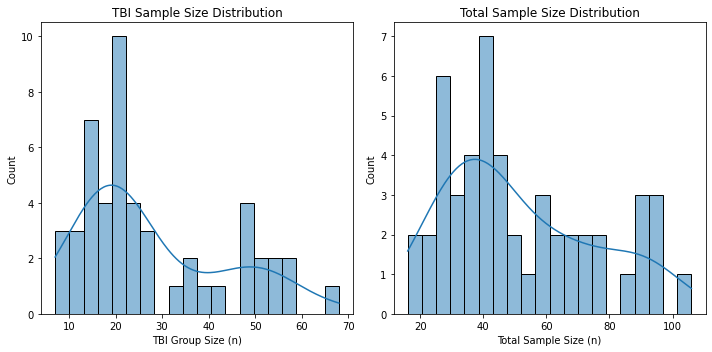

In [24]:
#check sample distributions
sample_sizes = sampleDist(data)

In [26]:
#Calculate quartiles for scoring cutoffs

#TBI
print('TBI percentiles:')
print(np.percentile(sample_sizes[0], 25))
print(np.percentile(sample_sizes[0], 50))
print(np.percentile(sample_sizes[0], 75))
print('\n')

#Total
print('Total percentiles:')
print(np.percentile(sample_sizes[1], 25))
print(np.percentile(sample_sizes[1], 50))
print(np.percentile(sample_sizes[1], 75))
print('\n')

TBI percentiles:
16.25
22.0
39.25


Total percentiles:
33.25
43.5
68.75


